# **Backpropagation from Scratch**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Derivation is at the heart of backpropagation
Derivation helps us undrstand how a function behaves if the input is modified.Given a function f(x), how does the function behave if input x is modified with h i.e x+h.

In case of backpropagation, the inputs are weights and biases. We want to understand what happens if small changes(h) are made to x(weights and biases)

# Now lets take a simple equation f(x) to understand how the function behaviour changes upon increasing it with a small value

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5
  # return 4*x**2 - 5*x + 6

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
ys

array([100.  ,  83.75,  69.  ,  55.75,  44.  ,  33.75,  25.  ,  17.75,
        12.  ,   7.75,   5.  ,   3.75,   4.  ,   5.75,   9.  ,  13.75,
        20.  ,  27.75,  37.  ,  47.75])

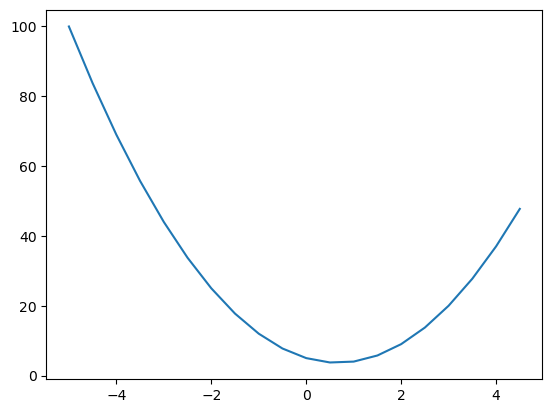

In [5]:
plt.plot(xs, ys)

In [6]:
x = 3.0

# to get a more accurate slope, coverge h towards 0
h = 0.00001
f(x+h)

20.0001400003

Now lets get the slope(f(x+h)-f(x))/h

In [7]:
(f(x+h)-f(x))/h

14.00003000000538

#one more example, a bit more complex

In [8]:
a = 2.0
b = -3.0
c = 10.0

# equation
d = a*b + c

print(d)

4.0


In [9]:
# observe the values when a is increased

def f1(a, b, c):
  return a*b + c

h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = f1(a, b, c)
d2 = f1(a+h, b, c)

# slope when a is increased by h
print("slope when a is increased: ",(d2-d1)/h)

d2 = f1(a, b+h, c)
# slope when b is increased by h
print("slope when b is increased: ",(d2-d1)/h)

d2 = f1(a, b, c+h)
# slope when c is increased by h
print("slope when c is increased: ",(d2-d1)/h)

slope when a is increased:  -3.000000000064062
slope when b is increased:  2.0000000000131024
slope when c is increased:  0.9999999999621422


Neural Networks have massive expressions so lets start with creating a data structure to maintain these expressions

In [10]:
class Operand:
    def __init__(self, value, _children = (), _operation=''):
        self.value = value
        self._prev_ops = set(_children)
        self._operation = _operation
    
    def __repr__(self):
        return f"Variable(value={self.value})"

    # adding two operands
    def __add__(self, other):
        addition = Operand(self.value + other.value, (self, other), '+')
        return addition

    # subtracting two operands

    # multiplying two operands
    def __mul__(self, other):
        product = Operand(self.value * other.value, (self, other), '*')
        return product

    # dividing two operands


In [11]:
a = Operand(2.0)
b = Operand(3.0)
c = Operand(4.0)
d = a*b + c
print(a + b)

d, d._prev_ops, d._operation

Variable(value=5.0)


(Variable(value=10.0), {Variable(value=4.0), Variable(value=6.0)}, '+')

 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__